## Trio不同方法计算比较及阈值确定

In [1]:
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
ldak_id = 'demo_data/trio_data/ldak5_nw.grm.id.txt'
ldak_mat = 'demo_data/trio_data/ldak5_nw.grm.raw.txt'
plink_cov_id = 'demo_data/trio_data/make_cal_cov.rel.id.txt'
plink_cov_mat = 'demo_data/trio_data/make_cal_cov.rel.txt'
plink_ibc2_id = 'demo_data/trio_data/make_cal_ibc2.rel.id.txt'
plink_ibc2_mat = 'demo_data/trio_data/make_cal_ibc2.rel.txt'
plink_ibc3_id = 'demo_data/trio_data/make_cal_ibc3.rel.id.txt'
plink_ibc3_mat = 'demo_data/trio_data/make_cal_ibc3.rel.txt'

In [3]:
## 读取数据
def get_dataFrame(id_file,mat_file,sep='\t'):
    ids=[]
    with open(id_file,'r') as f:
        line = f.readline()
        while line:
            cells = line.strip('\n').split('_')
            ids.append(cells[0])
            line=f.readline()
    pd_data = pd.read_csv(mat_file,sep=sep,header=None)
    pd_data.dropna(axis='columns',inplace=True)
    pd_data.dropna(inplace=True)
    pd_data.columns=ids
    pd_data['sample'] = ids
    pd_data.set_index('sample',inplace=True)
    return pd_data

def get_diag(pd_data):
    if pd_data.shape[0] == pd_data.shape[1]:
        diag=[pd_data.iloc[i,i] for i in range(pd_data.shape[0])]
    else:
        raise ValueError('方阵才能取diag,shape={}'.format(pd_data.shape))
    return diag


def get_relation(pd_data):
    mydict = {}
    for i in pd_data.columns:
        family = pd_data.loc[i,:][pd_data.loc[i,:]>0.1]
        if len(family) >1:
            family.drop(i,inplace=True)
            mydict.setdefault(i,{})
            for ele in family.index.tolist():
                if family[ele] >0.7:
                    mydict[i].setdefault(1,[])
                    mydict[i][1].append(ele)                
                elif family[ele] > 0.3:
                    mydict[i].setdefault(2,[])
                    mydict[i][2].append(ele)
                else:
                    mydict[i].setdefault(3,[])
                    mydict[i][3].append(ele)
    return mydict

In [4]:
ldak_pd = get_dataFrame(ldak_id,ldak_mat,sep=' ')
plink_cov_pd = get_dataFrame(plink_cov_id,plink_cov_mat)
plink_ibc2_pd = get_dataFrame(plink_ibc2_id,plink_ibc2_mat)
plink_ibc3_pd = get_dataFrame(plink_ibc3_id,plink_ibc3_mat)

# print(ldak_pd.head())
# print(plink_cov_pd.head())
# print(plink_ibc2_pd.head())
# print(plink_ibc3_pd.head())

In [5]:
ldak_diag = get_diag(ldak_pd)
cov_diag = get_diag(plink_cov_pd)
ibc2_diag = get_diag(plink_ibc2_pd)
ibc3_diag = get_diag(plink_ibc3_pd)
diag_pd = pd.DataFrame({'ldak':ldak_diag,
                        'cov':cov_diag,
                        'ibc2':ibc2_diag,
                        'ibc3':ibc3_diag})

all_pd = pd.DataFrame({'ldak':ldak_pd.stack(),
                        'cov':plink_cov_pd.stack(),
                        'ibc2':plink_ibc2_pd.stack(),
                        'ibc3':plink_ibc3_pd.stack()})


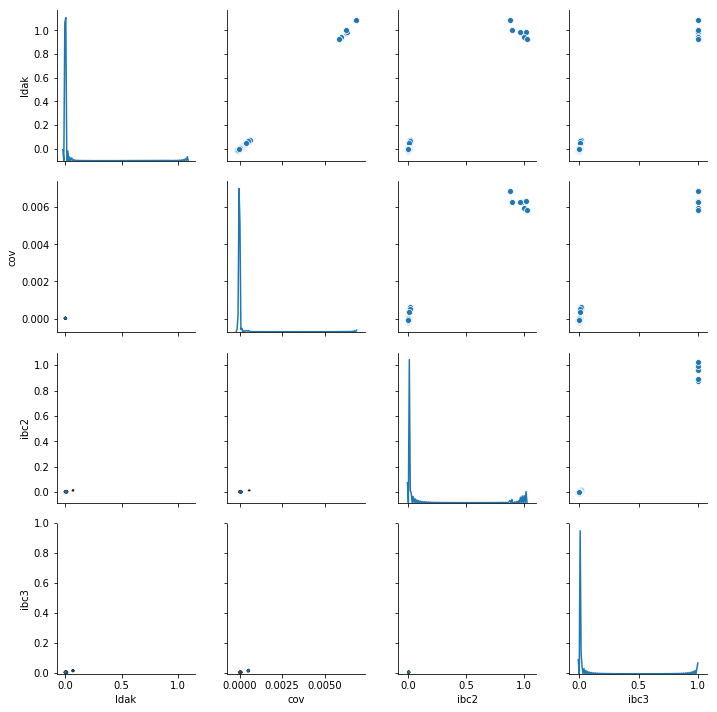

In [6]:

g = sns.PairGrid(all_pd.sample(5000), diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot)

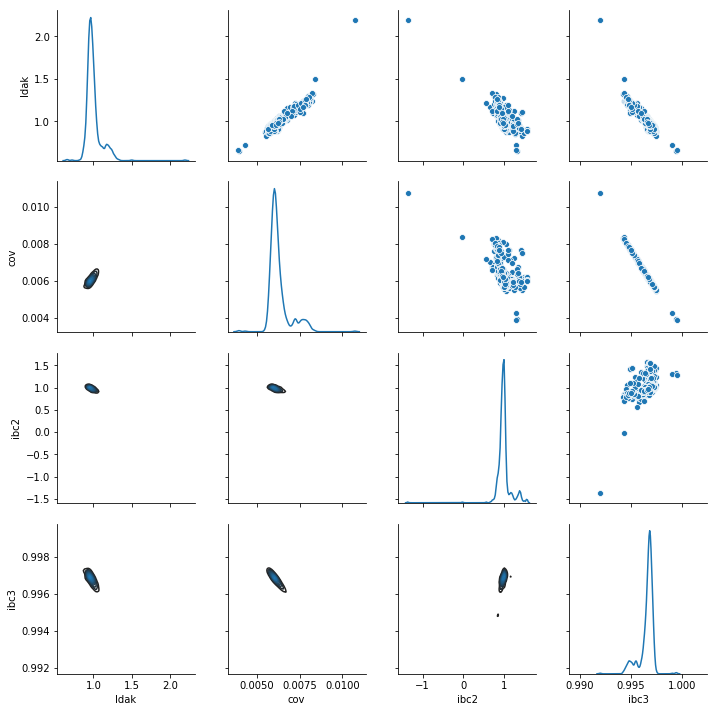

In [7]:
g = sns.PairGrid(diag_pd, diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot)

In [8]:
diag_de=diag_pd.describe()

ldak_mean = ldak_pd.stack().mean()
ldak_std = ldak_pd.stack().std()
ldak_mean_p =  diag_de['ldak']['mean']
ldak_std_p = diag_de['ldak']['std']

ibc3_mean = plink_ibc3_pd.stack().mean()
ibc3_std =plink_ibc3_pd.stack().std()
ibc3_mean_p = diag_de['ibc3']['mean']
ibc3_std_p = diag_de['ibc3']['std']

state=pd.DataFrame([['ldak',ldak_mean,ldak_std,ldak_mean_p,ldak_std_p],
                    ['ibc3',ibc3_mean,ibc3_std,ibc3_mean_p,ibc3_std_p]],columns=['type','mean','std','p_mean','p_std'])
state.set_index('type',inplace=True)

              mean       std    p_mean     p_std
type                                            
ldak -5.081571e-10  0.038108  1.000000  0.099347
ibc3 -3.119551e-11  0.036259  0.996564  0.000687


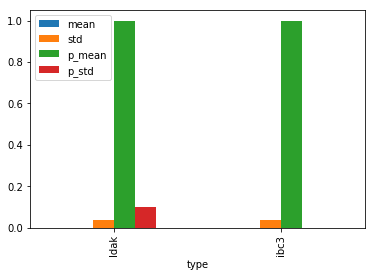

In [9]:
print(state)
state.plot.bar()

In [10]:
mydict=get_relation(ldak_pd)
mydict2=get_relation(plink_ibc3_pd)
            



In [11]:
# for i in mydict.keys():
#     print('（{}）`s family:'.format(i))
#     if 1 in mydict[i].keys():
#         print('重复或者同卵兄弟姐妹:{}'.format(','.join(mydict[i][1])))
#     if 2 in mydict[i].keys():
#         print('一级直系亲属（父母，子女，非同卵兄弟姐妹）:{}'.format(','.join(mydict[i][2])))
#     if 3 in mydict[i].keys():
#         print('二级直系亲属（叔侄，祖孙）:{}'.format(','.join(mydict[i][3])))
#     print('--'*20)

In [12]:
# print("|family|重复或者同卵兄弟姐妹|一级直系亲属（父母，子女，非同卵兄弟姐妹）|二级直系亲属（叔侄，祖孙）|")
# print("|:--:|:--:|:--:|:--:|")
# for i in mydict.keys():
#     table = '|{}|'.format(i)
#     if 1 in mydict[i].keys():
#         table = '{}{}|'.format(table,','.join(mydict[i][1]))
#     else:
#         table = '{}|'.format(table)
    
#     if 2 in mydict[i].keys():
#         table = '{}{}|'.format(table,','.join(mydict[i][2]))
#     else:
#         table = '{}|'.format(table)
#     if 3 in mydict[i].keys():
#         table = '{}{}|'.format(table,','.join(mydict[i][3]))
#     else:
#         table = '{}|'.format(table)
#     print(table)